# Fetch Circle Elevations
### Purpose
In this notebook I query the USGS to get elevation data for all of the circles.
This notebook addresses some one of the tasks in Github issue #35

### Author: 
Ian Davis
### Date: 
2020-03-31
### Update Date: 
2020-04-09

### Inputs 
1.1-circles_to_many_stations_usa_weather_data_20200405130930.csv - Comma separate file of the Christmas Bird Count and matches to 1 or more NOAA weather stations.
- Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

### Output Files
1.2-ijd-fetch-elevation-data.txt - Only 1 column is added to the dataset, 'circle_elev'. This column is the elevation in meters for a given latitude and longitude of the circle centroid.

## Steps or Proceedures in the notebook 
- Set runtime options
    - Set option to retrieve elevations from offline source, or through the USGS queries
    - Set option to only test the USGS query (NOTE: running the query function for the whole dataset will take 24+ hours)
- Create a function to make a remote request to the USGS API
- Create a function to supply inputs to the remote request and return the elevation value
- Main sequence
    - Read in dataset
    - Create circl_elev column
    - Loop through the dataset in chunks of 10000 to get elevation data
    - Write new dataset .txt file

## References
- elevation query: https://stackoverflow.com/questions/58350063/obtain-elevation-from-latitude-longitude-coordinates-with-a-simple-python-script
- lamda functions: https://thispointer.com/python-how-to-use-if-else-elif-in-lambda-functions/
- apply on Nulls: https://stackoverflow.com/questions/26614465/python-pandas-apply-function-if-a-column-value-is-not-null

In [1]:
# Imports 
import pandas as pd
import numpy as np
import requests
import urllib
import urllib3
import time

In [2]:
# Check to see if you are running 32-bit Python (output would be False)
# 32-bit Python could result in Memory Error when reading in large dataset
import sys
sys.maxsize > 2**32

False

## Set File Paths and Runtime Options

In [3]:
# File paths and script options
#PATH_TO_PAIRED_DATA = "../data/Cloud_Data/1.0-rec-initial-data-cleaning.txt"
PATH_TO_PAIRED_DATA = "../data/Cloud_Data/1.1-circles_to_many_stations_usa_weather_data_20200405130930.csv"
#PATH_TO_PAIRED_DATA = "../data/Cloud_Data/1.1-test.csv"

PATH_TO_OFFLINE_ELEVATION_DATA = "../attic/cbc_cleaned_usa_merged_elevation.csv"
#PATH_TO_OFFLINE_ELEVATION_DATA = "../attic/cbc-test.csv"

PATH_TO_LOG_FILE = "../data/Cloud_Data/1.2-ijd-fetch_circle_elevations.log"

# option to pull offline elevation data from the /attic instead of running the queries
get_offline_data = True

# option to run a simple test of the query; only 1000 rows are queried instead of full dataset
test_query = True

In [4]:
#paired_data = pd.read_csv(PATH_TO_PAIRED_DATA, encoding = "ISO-8859-1", sep="\t")
paired_data = pd.read_csv(PATH_TO_PAIRED_DATA, memory_map=True)
print(len(paired_data.index))

# temporary filter because Francisco is still working on the dataset
#paired_data_usa = paired_data[paired_data.id.str.slice(stop=2)=="US"]
paired_data = paired_data.loc[paired_data['id'].str.startswith('US')]
print(len(paired_data.index))

c:\users\ijd50\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1151128
1051895


## Make a new dataframe named df that we will add columns to.

In [5]:
df = paired_data
del(paired_data)

## Create a Log File

In [6]:
if not get_offline_data:
    log = open(PATH_TO_LOG_FILE, 'w')
    log.write('This log file shows the row index, lat, lon\n')

## Create a function to make a remote request to the USGS API

In [7]:
def make_remote_request(url: str, params: dict):
    """
    Makes the remote request
    Continues making attempts until it succeeds
    """

    count = 1
    while True:
        try:
            response = requests.get((url + urllib.parse.urlencode(params)))
            #print(params)
            time.sleep(1)
        except (OSError, urllib3.exceptions.ProtocolError) as error:
            print('\n')
            print('*' * 20, 'Error Occured', '*' * 20)
            print(f'Number of tries: {count}')
            print(f'URL: {url}')
            print(error)
            print('\n')
            count += 1
            time.sleep(0.5)
            continue
        break

    return response

## Create a function to supply inputs to the remote request and return the elevation value

In [8]:
def elevation_function(x):
    """
    x - longitude
    y - latitude
    returns elevation in meters
    """
    
    url = 'https://nationalmap.gov/epqs/pqs.php?'
    params = {'x': x[1],
              'y': x[0],
              'units': 'Meters',
              'output': 'json'}
    log.write(str(x.name)+'\t\t'+str(x[0])+'\t\t'+str(x[1])+'\n')   # print row index, lat, lon
    result = make_remote_request(url, params)
    
    return result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']

## Loops to Query the USGS API

In [9]:
# Boolean to skip loop of queries and just pull elevation data from the "attic"
if not get_offline_data:
    # create elevation column
    df.loc[:, 'circle_elev'] = np.nan

In [10]:
# Boolean to skip loop of queries and just pull elevation data from the "attic"
if not get_offline_data:
    # initial list of indices which are missing elevations
    missing = df.loc[df['circle_elev'].isnull()].index

In [11]:
# while loop to go over the dataset several times in the event that query requests fail

# Boolean to skip loop of queries and just pull elevation data from the "attic"
if not get_offline_data:
    cnt=0 # counter to break while loop after
    while len(missing) > 0:
        if cnt == 5: break # exit while loop
        cnt+=1
        log.write('while counter: '+str(cnt)+'\n')
        
        # boolean to setup a test run for only 1 iteration in the for loop
        if test_query:
            end=1
        else:
            # break query up into loops of 1000
            end = int(np.ceil(len(df.index)/1000))
        
        for i in range(0,end):
            j = i*1000
            k = j+999
            try:
                # combination of apply() function and lambda() function, only on nulls (see reference links above)
                df.loc[j:k, 'circle_elev'] = df.loc[j:k, ['lat', 'lon', 'circle_elev']].apply(lambda x: elevation_function(x[0:2]) if(pd.isnull(x[2])) else x[2], axis=1)
            except:
                # on occasion query completely fails and crashes the function call
                continue
            # Intermediate writes to .csv file so work is not lost in the event of code failure
            df.to_csv("../data/Cloud_Data/1.2-ijd-fetch-circle-elevations.txt", sep="\t")
    
        # get new list of missing indices
        missing = df.loc[df['circle_elev'].isnull()].index
        # break the loop if there are no missing elevations
        if len(missing) == 0: break
    
    # Rename dataframe (so that it is consistent with dataframe name below)
    filtered_data = df
    del(df)
    
    # close log file
    log.close()

## (Optional) Get Elevation Data from Offline Source

In [12]:
if get_offline_data:
    # load offline data file
    #df_offline = pd.read_csv(PATH_TO_OFFLINE_ELEVATION_DATA)
    data_iterator = pd.read_csv(PATH_TO_OFFLINE_ELEVATION_DATA, chunksize=10000)
    
    # convert count_date to string or merge won't match them properly
    #df_offline['count_date'] = pd.to_datetime(df_offline['count_date'])
    df['count_date'] = pd.to_datetime(df['count_date'])
    
    chunk_list = []  

    # Each chunk is in dataframe format
    for data_chunk in data_iterator:
        data_chunk['count_date'] = pd.to_datetime(data_chunk['count_date'])
        filtered_chunk = pd.merge(df, data_chunk[['lat', 'lon', 'count_date', 'circle_elev']], on=['lat', 'lon', 'count_date'])
        chunk_list.append(filtered_chunk)
    
    filtered_data = pd.concat(chunk_list)

In [13]:
# Ensure elevations are the float
filtered_data.loc[:, 'circle_elev'] = filtered_data.loc[:, 'circle_elev'].astype(float)

In [14]:
# Remove bad elevation values
filtered_data.loc[filtered_data['circle_elev'] < 0.0, 'circle_elev'] = np.nan 

In [15]:
filtered_data[['lat', 'lon', 'count_date', 'circle_elev']].head(50)

,lat,lon,count_date,circle_elev
0,46.681224,-68.015489,1933-12-23,138.62
1,46.681224,-68.015489,1933-12-23,138.62
2,46.681224,-68.015489,1933-12-23,138.62
3,46.681224,-68.015489,1933-12-23,138.62
4,46.681224,-68.015489,1934-12-22,138.62
5,46.681224,-68.015489,1934-12-22,138.62
6,46.681224,-68.015489,1934-12-22,138.62
7,46.681224,-68.015489,1934-12-22,138.62
8,46.681224,-68.015489,1936-12-21,138.62
9,46.681224,-68.015489,1936-12-21,138.62


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2B403190>]],
      dtype=object)

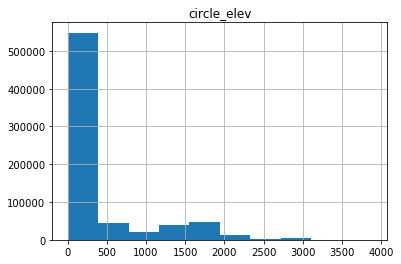

In [16]:
# Create histogram of elevations
filtered_data.hist(column='circle_elev')

In [17]:
len(filtered_data.index)

724261

In [18]:
len(df.index)

1051895

## Save the output

In [20]:
filtered_data.to_csv("../data/Cloud_Data/1.2-ijd-fetch-circle-elevations.txt", sep="\t")